In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST, CIFAR10

# Note: we will load the IMDB dataset from tensorflow.keras...
from tensorflow.keras.datasets import imdb
import tensorflow as tf
from tensorflow import keras
import gc
from sklearn.model_selection import train_test_split

from torch.nn import Linear, Conv2d, MaxPool2d, Dropout, Flatten, ReLU
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### PyTorch version: ' + torch.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())


------------
### Python version: 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
### NumPy version: 1.24.4
### Scikit-learn version: 0.24.2
### PyTorch version: 1.13.1
------------


In [2]:
# check if the unzipped directory exists, if not, unzip it
directory = "project_data"
zippedDir = directory + ".zip"
if not os.path.isdir(directory):
    import zipfile
    with zipfile.ZipFile(zippedDir, 'r') as myzip:
        myzip.extractall(directory)

In [3]:
from PIL import Image
from pathlib import Path
dirNames = []

def getData():
    imageCounter = 0
    images = []
    labels = []
    for classes in Path(directory).iterdir():
        dirNames.append(os.path.basename(classes))
        try:
            for image in classes.iterdir():
                imageCounter += 1
                img = np.array(Image.open(image).convert("RGB"))
                img = np.transpose(img, (2, 0, 1))
                images.append(img)
                labels.append(os.path.basename(classes))
        except:
            continue
    print(imageCounter)
    return np.array(images), np.array(labels), imageCounter

In [4]:
import matplotlib.pyplot as plt

def visualizeData(x, y):
    # visualize to make sure images have loaded with correct labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        # For visualization, transpose back to (H, W, C)
        img_to_show = np.transpose(x[i], (1, 2, 0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_to_show)
        plt.title(y[i])
        plt.axis("off")
    plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # shape: [N, 3, 128, 128]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype('uint8')  # shape: [3, 128, 128]
        img = np.transpose(img, (1, 2, 0))      # → [128, 128, 3] for ToPILImage
        img = ToPILImage()(img)                 # now valid
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ResNetConvNet128(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        
        # Load ResNet18 backbone, exclude final FC
        resnet = resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Keeps up to last conv block

        # Adaptive pooling to handle output size
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Output shape: (batch, 512, 1, 1)

        # Custom classifier head
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.features(x)              # → [B, 512, H, W]
        x = self.pool(x)                  # → [B, 512, 1, 1]
        x = torch.flatten(x, 1)           # → [B, 512]
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.fc3(x)


In [7]:
from sklearn.preprocessing import LabelEncoder

images, labels, count = getData()


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(labels_encoded)

4757
[8 8 8 ... 9 9 9]


In [8]:
transform = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),  # ← Converts PIL to Tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


dataset = CustomImageDataset(images, labels_encoded, transform=train_transform)

# Define the split sizes
val_size = int(0.1 * len(dataset))  # 10% of the dataset for validation
test_size = int(0.1 * len(dataset))  # 10% of the dataset for testing
train_size = len(dataset) - val_size - test_size  # Remaining 80% for training

# Perform the dataset split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# DataLoader for batching
n_batch = 32
train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)


In [9]:
# Check a batch from the new train_loader
for i, data in enumerate(train_loader):
    inputs, temp = data  # inputs: [B, 3, 128, 128]

    # Ensure inputs are float tensors (they should be after ToTensor + Normalize)
    inputs = inputs.float()

    # Get global min and max across the entire batch
    min_val = inputs.min().item()
    max_val = inputs.max().item()

    if min_val < -1 or max_val > 1:
        print("Sample out of range:")
    else:
        print("All good - Images are normalized to [-1,1]")

    # Print min and max values found in the batch
    print(f"Min value in batch: {min_val:.5f}")
    print(f"Max value in batch: {max_val:.5f}")
    print(temp)

    break  # Check only the first batch


Sample out of range:
Min value in batch: -2.11790
Max value in batch: 2.64000
tensor([ 2,  5,  4,  1,  9,  9, 10,  5,  5, 10,  4,  0, 10,  7,  3,  4,  3,  2,
         6,  8,  8, 11,  9,  1,  5, 10,  7, 10,  9,  5, 10,  6])


In [10]:
print(labels_encoded)

[8 8 8 ... 9 9 9]


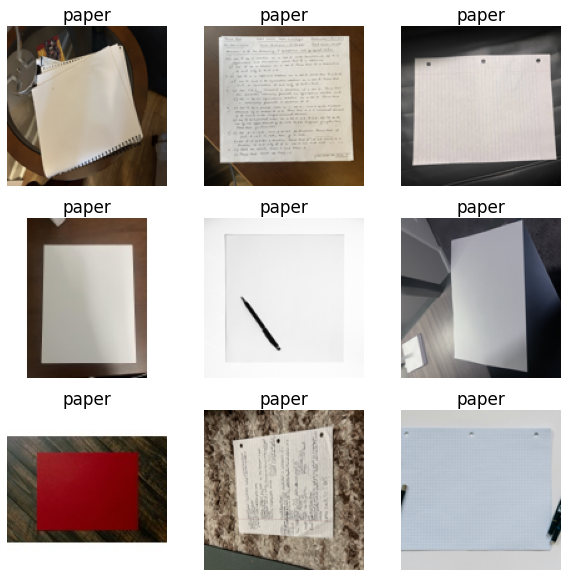

In [11]:
visualizeData(images, labels)

In [12]:
# Initialize model, cross entropy loss, and learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

model = ResNetConvNet128()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

cuda


In [13]:
import time
import torch

max_epochs = 200
train_loss_logs = []
val_loss_logs = []
train_acc_logs = []
val_acc_logs = []

best_val_loss = float('inf')  # Initialize best validation loss to infinity
best_model_wts = None  # Variable to store the best model weights

start = time.time()
print(f"{'Epoch':<6} | {'Train Loss':<10} | {'Train Acc':<10} | {'Val Loss':<10} | {'Val Acc':<10}")
print("-" * 55)

for epoch in range(max_epochs):
    model.train(True)
    running_loss = 0.0
    running_acc = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        running_acc += torch.sum(predicted == labels)
        max_minibatch = len(train_loader)

        if i % max_minibatch == max_minibatch - 1:
            avg_train_loss = running_loss / max_minibatch
            avg_train_acc = running_acc / (max_minibatch * n_batch)
            train_loss_logs.append(avg_train_loss)
            train_acc_logs.append(avg_train_acc)

            model.eval()
            with torch.no_grad():
                X_val, t_val = next(iter(val_loader))
                X_val = X_val.float().to(device)
                t_val = t_val.to(device)
                y_val = model(X_val)
                val_loss = loss_fn(y_val, t_val).item()
                _, pred_val = torch.max(y_val, 1)
                val_acc = torch.sum(pred_val == t_val).item() / len(val_dataset)
                val_loss_logs.append(val_loss)
                val_acc_logs.append(val_acc)

            # Save the model if the validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = model.state_dict()  # Save the best model weights

            print(f"{epoch:<6} | {avg_train_loss:<10.3f} | {avg_train_acc:<10.3f} | {val_loss:<10.3f} | {val_acc:<10.3f}")

            running_loss = 0.0
            running_acc = 0.0

# Load the best model weights after training
model.load_state_dict(best_model_wts)

# Test the best model on the test dataset
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_acc += torch.sum(predicted == labels)

test_loss /= len(test_loader)
test_acc /= len(test_dataset)

print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Save the best model to a .pt file
torch.save(model.state_dict(), 'model.pt')

end = time.time()
print('Finished Training')
print(f'Took {(end-start)//60:.0f} minutes and {(end-start)%60:.1f} seconds')


Epoch  | Train Loss | Train Acc  | Val Loss   | Val Acc   
-------------------------------------------------------
0      | 2.484      | 0.109      | 2.409      | 0.238     
1      | 2.396      | 0.160      | 2.302      | 0.446     
2      | 2.295      | 0.248      | 2.166      | 0.585     
3      | 2.148      | 0.349      | 1.951      | 0.684     
4      | 1.988      | 0.436      | 1.755      | 0.756     
5      | 1.829      | 0.496      | 1.538      | 0.762     
6      | 1.668      | 0.562      | 1.322      | 0.785     
7      | 1.476      | 0.627      | 1.159      | 0.789     
8      | 1.345      | 0.667      | 0.991      | 0.838     
9      | 1.211      | 0.695      | 0.893      | 0.842     
10     | 1.094      | 0.736      | 0.767      | 0.840     
11     | 0.996      | 0.756      | 0.692      | 0.855     
12     | 0.934      | 0.768      | 0.628      | 0.857     
13     | 0.863      | 0.794      | 0.564      | 0.874     
14     | 0.795      | 0.805      | 0.517      | 0.872     
